In [1]:
import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW, SGD 

import json

In [2]:
import utils_generic as generic
import singletask_dep as st
import model_confs as confs


import train_dep as train

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
torch.manual_seed(27)

In [4]:
model_conf = confs.distilbert_conf
encoding_type = 'pos'

# Datos ConvAI2

In [5]:
with open('Datasets\ConvAI2\convai2_complete.json','r') as f:
    data = json.load(f)

In [6]:
vocab = st.Vocabulary(data['train'],encoding_type)

In [7]:
convai_train = data['train']
convai_val = data['validation']



convai_train_token = generic.tokenize_dataset_with_dependencies(convai_train,['about','to','as'],vocab,model_conf) 
convai_val_token = generic.tokenize_dataset_with_dependencies(convai_val,['about','to','as'],vocab,model_conf) 

In [8]:
convai_train_dataset = {}
for task in ['to','as','about']:
    convai_train_dataset[task] = st.DatasetSingleTaskDep(convai_train_token,task,eval=False)

In [9]:
convai_val_dataset = {}
for task in ['to','as','about']:
    convai_val_dataset[task] = st.DatasetSingleTaskDep(convai_val_token,task,eval=False)

# Datos md_gender

In [10]:
with open('Datasets\md_gender\md_complete.json','r',encoding="utf8") as f:
    md_data = json.load(f)

In [11]:
md_tokenized = generic.tokenize_dataset_with_dependencies(md_data,['about','to','as'],vocab,model_conf) 


md_dataset = {}
for task in ['to','as','about']:
    md_dataset[task] = st.DatasetSingleTaskDep(md_tokenized,task,eval=True)

# Creación dataloaders

In [12]:
dl_train = {}
for task in ['to','as','about']:
    dl_train[task] = DataLoader(convai_train_dataset[task],batch_size=128,shuffle=True,collate_fn=st.collate_fn)

In [13]:
dl_val = {}
for task in ['to','as','about']:
    dl_val[task] = DataLoader(convai_val_dataset[task],batch_size=128,shuffle=True,collate_fn=st.collate_fn)

In [14]:
dl_eval = {}
for task in ['to','as','about']:
    dl_eval[task] = DataLoader(md_dataset[task],batch_size=128,shuffle=False,collate_fn=st.collate_fn)

# ABOUT

In [15]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='m1_distilbert_dep_pos_ABOUT_adam'

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.5815106933021379 	 Validation loss: 0.42263308874631333 	 
  1%|          | 574/57400 [02:32<4:37:58,  3.41it/s]
Epoch 2 	 Training loss: 0.3919932511002345 	 Validation loss: 0.35924638681492566 	 
  2%|▏         | 1148/57400 [05:28<5:44:37,  2.72it/s]
Epoch 3 	 Training loss: 0.35164804585303994 	 Validation loss: 0.34548155887652254 	 
  3%|▎         | 1722/57400 [08:57<5:42:06,  2.71it/s]
Epoch 4 	 Training loss: 0.3345177336644628 	 Validation loss: 0.33296803119829144 	 
  4%|▍         | 2296/57400 [12:27<4:20:59,  3.52it/s]
Epoch 5 	 Training loss: 0.31935371243060673 	 Validation loss: 0.3259073543851658 	 
  5%|▌         | 2870/57400 [15:22<4:32:14,  3.34it/s]
Epoch 6 	 Training loss: 0.30895453460436667 	 Validation loss: 0.3200524535219548 	 
  6%|▌         | 3444/57400 [18:20<4:28:53,  3.34it/s]
Epoch 7 	 Training loss: 0.29986689107343295 	 Validation loss: 0.3157919812000404 	 
  7%|▋         | 4018/57400 [21:34<4:23:58,  3.37it/s]
Epoch 8 	 Tra

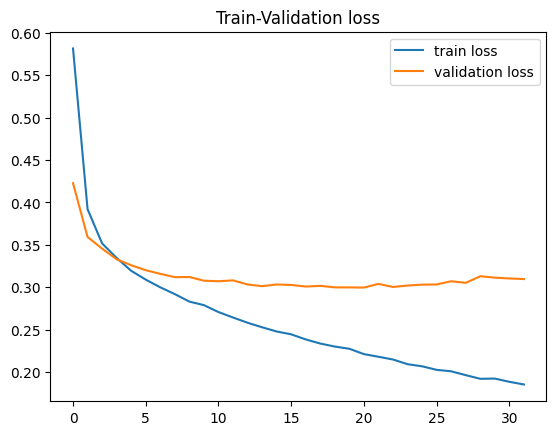

In [16]:
learning_rate = 1e-6
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
num_epochs = 100

train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path)

In [17]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Using scikit learn accuracy por género en el conjunto about
GLOBAL: 0.8392857142857143
MALE 0.8463541666666666
FEMALE 0.8325 

Using scikit learn accuracy por género en el conjunto to
GLOBAL: 0.6679292929292929
MALE 0.683698296836983
FEMALE 0.6509186351706037 

Using scikit learn accuracy por género en el conjunto as
GLOBAL: 0.6831812255541069
MALE 0.6742424242424242
FEMALE 0.692722371967655 



# TO

In [18]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='m1_distilbert_dep_pos_TO_adam'

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6948288818269657 	 Validation loss: 0.6910807268094208 	 
  1%|          | 574/57400 [02:47<4:51:41,  3.25it/s]
Epoch 2 	 Training loss: 0.693983902810758 	 Validation loss: 0.6931134371434228 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [06:11<5:22:39,  2.91it/s]
Epoch 3 	 Training loss: 0.6937209494437906 	 Validation loss: 0.6934922852758634 	 

2 epoch without improvement
  3%|▎         | 1722/57400 [09:00<5:53:18,  2.63it/s]
Epoch 4 	 Training loss: 0.6932800313529237 	 Validation loss: 0.6955175531112542 	 

3 epoch without improvement
  4%|▍         | 2296/57400 [12:54<4:07:59,  3.70it/s]
Epoch 5 	 Training loss: 0.6932422203053996 	 Validation loss: 0.6937090714099043 	 

4 epoch without improvement
  5%|▌         | 2870/57400 [16:22<4:23:38,  3.45it/s]
Epoch 6 	 Training loss: 0.6929612433868834 	 Validation loss: 0.6938304022207098 	 

5 epoch without improvement
  6%|▌         | 3444/57400 [19:26<4:35:18,  3.27it/s]
Epoch 7 	 Trainin

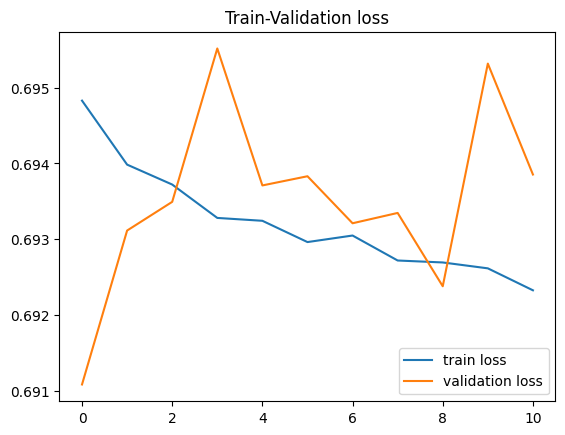

In [19]:
learning_rate = 1e-6
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
num_epochs = 100

train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path)

In [20]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Using scikit learn accuracy por género en el conjunto about
GLOBAL: 0.49489795918367346
MALE 0.044270833333333336
FEMALE 0.9275 

Using scikit learn accuracy por género en el conjunto to
GLOBAL: 0.48358585858585856
MALE 0.06569343065693431
FEMALE 0.9343832020997376 

Using scikit learn accuracy por género en el conjunto as
GLOBAL: 0.4810951760104302
MALE 0.050505050505050504
FEMALE 0.9407008086253369 



# AS

In [21]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='m1_distilbert_dep_pos_AS'

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6944758613765862 	 Validation loss: 0.6922246005575535 	 
  1%|          | 574/57400 [03:24<5:43:40,  2.76it/s]
Epoch 2 	 Training loss: 0.6929443421471825 	 Validation loss: 0.6916837934720315 	 
  2%|▏         | 1148/57400 [06:10<4:13:58,  3.69it/s]
Epoch 3 	 Training loss: 0.6915371118937635 	 Validation loss: 0.6918534444550336 	 
  3%|▎         | 1722/57400 [09:09<9:19:39,  1.66it/s]
Epoch 4 	 Training loss: 0.6901076728873967 	 Validation loss: 0.6917748461335392 	 
  4%|▍         | 2296/57400 [12:44<5:34:00,  2.75it/s]
Epoch 5 	 Training loss: 0.6886778582886952 	 Validation loss: 0.690820271685972 	 
  5%|▌         | 2870/57400 [15:39<4:35:52,  3.29it/s]
Epoch 6 	 Training loss: 0.6879472920495874 	 Validation loss: 0.6904090218624827 	 
  6%|▌         | 3444/57400 [19:01<5:47:35,  2.59it/s]
Epoch 7 	 Training loss: 0.6866304516169253 	 Validation loss: 0.693850787009223 	 

1 epoch without improvement
  7%|▋         | 4018/57400 [22:30<4:31:55,  3.27

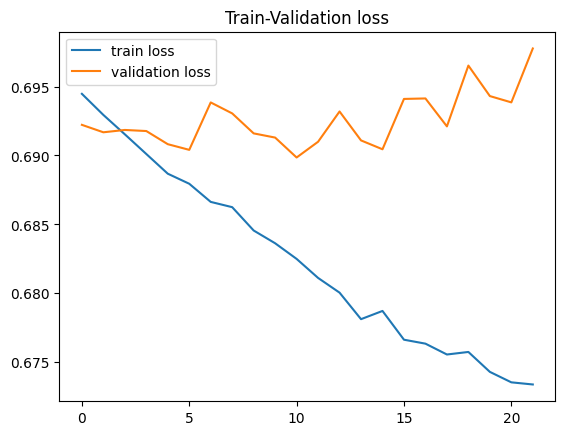

In [22]:
learning_rate = 1e-6
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
num_epochs = 100

train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path)

In [23]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Using scikit learn accuracy por género en el conjunto about
GLOBAL: 0.673469387755102
MALE 0.6458333333333334
FEMALE 0.7 

Using scikit learn accuracy por género en el conjunto to
GLOBAL: 0.6477272727272727
MALE 0.6472019464720195
FEMALE 0.6482939632545932 

Using scikit learn accuracy por género en el conjunto as
GLOBAL: 0.6857887874837028
MALE 0.6111111111111112
FEMALE 0.7654986522911051 

